In [1]:
data_to_be_discussed = "lockdown"

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
import sqlite3
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection  import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection  import cross_val_score
from collections import Counter
from sklearn import model_selection
from sklearn.metrics import roc_auc_score
from textblob import TextBlob 
import tweepy
from tweepy import Stream
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

# TWITTER STREAMER

In [3]:
class TwitterStreamer():
  
    def __init__(self):
        self.twitter_autenticator = TwitterAuthenticator()    

    def stream_tweets(self, fetched_tweets_filename, hash_tag_list):
        
        # Handling Twitter authetification and the connection to Twitter Streaming API
        
        listener = TwitterListener(fetched_tweets_filename)
        auth = self.twitter_autenticator.authenticate_twitter_app() 
        stream = Stream(auth, listener)
        
        stream.filter(track=hash_tag_list)    # Filtering Twitter Streams to capture data by the keywords:

# TWITTER STREAM LISTENER

In [4]:
class TwitterListener(StreamListener):
    
    def __init__(self, fetched_tweets_filename):
        self.fetched_tweets_filename = fetched_tweets_filename

    def on_data(self, data):
        try:
            print(data)
            with open(self.fetched_tweets_filename, 'a') as tf:
                tf.write(data)
            return True
        except BaseException as e:
            print("Error on_data %s" % str(e))
        return True
          
    def on_error(self, status):
        if status == 420:   # Returning False on_data method in case rate limit occurs.
            return False
        print(status)

# TWITTER CLIENT

In [5]:
class TwitterClient():
    def __init__(self, twitter_user=None):
        self.auth = TwitterAuthenticator().authenticate_twitter_app()
    
        self.twitter_client = tweepy.API(self.auth)

        self.twitter_user = twitter_user

    def get_twitter_client_api(self):
        return self.twitter_client

    def get_user_timeline_tweets(self, num_tweets):
        tweets = []
        for tweet in Cursor(self.twitter_client.user_timeline, id=self.twitter_user).items(num_tweets):
            tweets.append(tweet)
        return tweets

    def get_friend_list(self, num_friends):
        friend_list = []
        for friend in Cursor(self.twitter_client.friends, id=self.twitter_user).items(num_friends):
            friend_list.append(friend)
        return friend_list

    def get_home_timeline_tweets(self, num_tweets):
        home_timeline_tweets = []
        for tweet in Cursor(self.twitter_client.home_timeline, id=self.twitter_user).items(num_tweets):
            home_timeline_tweets.append(tweet)
        return home_timeline_tweets

# TWITTER AUTHENTICATER

In [6]:
consumer_key='CQEETH8y2aRjmZ09rcaKq31xW'
consumer_secretkey='S06XahozWM2UclNjOWNDa950ovZZSeR2ROO80PU9BKfG2HTXUc'
tokenkey='1099592114160099328-bjBkGXkwvRbQDwlODzlJJCoUVwOSha'
token_secretkey='wqp5M4xrfumwEwL7K5eVvX7r7YLnBpK41SSLmA2rve2EW'
consumer_secret='S06XahozWM2UclNjOWNDa950ovZZSeR2ROO80PU9BKfG2HTXUc'
access_token='1099592114160099328-bjBkGXkwvRbQDwlODzlJJCoUVwOSha'
access_token_secret='wqp5M4xrfumwEwL7K5eVvX7r7YLnBpK41SSLmA2rve2EW'

In [7]:
class TwitterAuthenticator():

    def authenticate_twitter_app(self):
        auth = OAuthHandler(consumer_key, consumer_secretkey)
        auth.set_access_token(tokenkey, token_secretkey)
        return auth

# TWITTER ANALYZER in DF

In [8]:
class TweetAnalyzer():
 
    def tweets_to_data_frame(self, tweets):
        df = pd.DataFrame(data=[tweet.text for tweet in tweets], columns=['tweets'])

        df['id'] = np.array([tweet.id for tweet in tweets])
        df['len'] = np.array([len(tweet.text) for tweet in tweets])
        df['date'] = np.array([tweet.created_at for tweet in tweets])
        df['source'] = np.array([tweet.source for tweet in tweets])
        df['likes'] = np.array([tweet.favorite_count for tweet in tweets])
        df['retweets'] = np.array([tweet.retweet_count for tweet in tweets])
        

        return df 

# MAIN BODY

In [9]:
import pandas as pd
from textblob import TextBlob
import numpy as np

if __name__ == '__main__':

   
    twitter_client = TwitterClient()
    tweet_analyzer = TweetAnalyzer()

    api = twitter_client.get_twitter_client_api()

    tweets = api.user_timeline(screen_name=data_to_be_discussed, count=100)

    adf = tweet_analyzer.tweets_to_data_frame(tweets)

    print(adf.head(10))

                                              tweets                   id  \
0  Keep working kid!! @justinbradford_  #2021Clas...  1261136883595096070   
1  Congrats again Siz! Good Work Scott!! https://...  1260787091685793793   
2  Congratulations JB! Great decision and great d...  1260705392260083712   
3  Keep working in the Darkness! #MakeItHappen #N...  1260025381295276032   
4  Congrats JB on your first season at new school...  1259940684632489984   
5     RT @BVEvery: More than 20 offers for Bradford!  1254847673951088640   
6  Attacking week 6 of quarantine...Go Get It!! h...  1254845129719820288   
7  Work in the Darkness, so when the light shines...  1254823943162085378   
8  Smooth transition from pedal to crossover, goo...  1253816252407013376   
9  Good job getting your head around to relocate ...  1253813407712546816   

   len                date              source  likes  retweets  
0   81 2020-05-15 03:30:38  Twitter for iPhone     13         2  
1   61 2020-05-14 04

In [10]:
adf

,tweets,id,len,date,source,likes,retweets
0,Keep working kid!! @justinbradford_ #2021Clas...,1261136883595096070,81,2020-05-15 03:30:38,Twitter for iPhone,13,2
1,Congrats again Siz! Good Work Scott!! https://...,1260787091685793793,61,2020-05-14 04:20:41,Twitter for iPhone,9,0
2,Congratulations JB! Great decision and great d...,1260705392260083712,131,2020-05-13 22:56:02,Twitter for iPhone,11,1
3,Keep working in the Darkness! #MakeItHappen #N...,1260025381295276032,78,2020-05-12 01:53:55,Twitter for iPhone,10,2
4,Congrats JB on your first season at new school...,1259940684632489984,140,2020-05-11 20:17:22,Twitter for iPhone,4,0
...,...,...,...,...,...,...,...
95,"Happy Mother’s Day to the the Past, Present , ...",995812381015109633,140,2018-05-13 23:45:47,Twitter for iPhone,23,2
96,Up and at it!!!! On the hunt early this am!! h...,995656830834491393,68,2018-05-13 13:27:41,Twitter for iPhone,57,3
97,Preach!! https://t.co/amkCxYbKbU,993728355642961920,32,2018-05-08 05:44:37,Twitter for iPhone,23,4
98,Keep carrying them ‘Bron!! Fun to watch!!!,993727434380881920,42,2018-05-08 05:40:57,Twitter for iPhone,13,0


In [11]:
adf1=adf[["tweets"]]

In [12]:
adf1.head(10)

,tweets
0,Keep working kid!! @justinbradford_ #2021Clas...
1,Congrats again Siz! Good Work Scott!! https://...
2,Congratulations JB! Great decision and great d...
3,Keep working in the Darkness! #MakeItHappen #N...
4,Congrats JB on your first season at new school...
5,RT @BVEvery: More than 20 offers for Bradford!
6,Attacking week 6 of quarantine...Go Get It!! h...
7,"Work in the Darkness, so when the light shines..."
8,"Smooth transition from pedal to crossover, goo..."
9,Good job getting your head around to relocate ...


In [13]:
adf1.to_csv('tweets.csv',index = False) 

# Training dataset

In [14]:
import ast

In [15]:
df = pd.concat([pd.read_csv('amazon_cells_labelled.txt', sep="	", header=None, names=["text", "label"]),
                pd.read_csv('imdb_labelled.txt', sep="	", header=None, names=["text", "label"]),
                pd.read_csv('yelp_labelled.txt', sep="	", header=None, names=["text", "label"])])

In [16]:
df.head()

,text,label
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


In [17]:
df.shape

(2748, 2)

In [18]:
final=df.drop('label',axis=1)
target=df['label']

In [19]:
sent_0 = final['text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['text'].values[1500]
print(sent_1500)
print("="*50)

sent_2000 = final['text'].values[2000]
print(sent_2000)
print("="*50)

sent_2500 = final['text'].values[2500]
print(sent_2500)
print("="*50)

So there is no way for me to plug it in here in the US unless I go by a converter.
A very, very, very slow-moving, aimless movie about a distressed, drifting young man.  
It's a case of 'so bad it is laughable'.  
The Greek dressing was very creamy and flavorful.
Level 5 spicy was perfect, where spice didn't over-whelm the soup.


In [20]:
import re
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase.replace("’","'"))
    phrase = re.sub(r"can\'t", "can not", phrase.replace("’","'"))

    # general
    phrase = re.sub(r"n\'t", " not", phrase.replace("’","'"))
    phrase = re.sub(r"\'re", " are", phrase.replace("’","'"))
    phrase = re.sub(r"\'s", " is", phrase.replace("’","'"))
    phrase = re.sub(r"\'d", " would", phrase.replace("’","'"))
    phrase = re.sub(r"\'ll", " will", phrase.replace("’","'"))
    phrase = re.sub(r"\'t", " not", phrase.replace("’","'"))
    phrase = re.sub(r"\'ve", " have", phrase.replace("’","'"))
    phrase = re.sub(r"\'m", " am", phrase.replace("’","'"))
    return phrase

In [21]:
sent_490 = decontracted(sent_0)
print(sent_490)
print("="*50)
#sent_0 = decontracted(sent_0)
#print(sent_0)


So there is no way for me to plug it in here in the US unless I go by a converter.


In [22]:
from nltk.corpus import stopwords

In [23]:
stopWords =set(stopwords.words('english'))

In [24]:
print(stopWords.remove('nor'))
print(stopWords.remove('not'))
print(stopWords.remove('no'))

None
None
None


In [25]:
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['text'].values):
    #sentance = re.sub(r"http\S+", "", sentance)
    #sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopWords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 2748/2748 [00:00<00:00, 14499.80it/s]


In [26]:
preprocessed_reviews[0]

'no way plug us unless go converter'

#  Applying KNN brute force on BAG OF WORDS

In [27]:
fdf = target.loc[target.index<1]
dfdf = fdf.to_frame('newCol')
print(dfdf)

   newCol
0       0
0       0
0       1


In [28]:
from sklearn.model_selection  import train_test_split

x= preprocessed_reviews
y= target
count_vect=CountVectorizer()


X_train = preprocessed_reviews
X_test = adf1["tweets"]
y_train = target



X_tr, X_cv, y_tr, y_cv = train_test_split(X_train, y_train, test_size=0.3)
print('Number of data points in train data:', len(X_test))
print('Number of data points in test data:', len(X_tr))
print('Number of data points in cross validation data:', len(X_cv))

Number of data points in train data: 100
Number of data points in test data: 1923
Number of data points in cross validation data: 825


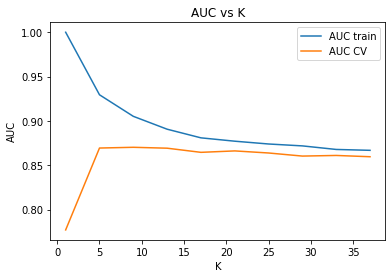

In [29]:
final_Xtr=count_vect.fit_transform(X_tr)
final_Xcv=count_vect.transform(X_cv)
final_Xtest=count_vect.transform(X_test)
auc_cv=[]
auc_train=[]
K=list(range(1,40,4))
cv_scores=[]
for i in K:
    knn=KNeighborsClassifier(n_neighbors=i,weights='uniform',algorithm='brute',leaf_size=30, p=2, metric='cosine')
    knn.fit(final_Xtr, y_tr)
    pred = knn.predict_proba(final_Xcv)[:,1]
    auc_cv.append(roc_auc_score(y_cv,pred))
    pred1=knn.predict_proba(final_Xtr)[:,1]
    auc_train.append(roc_auc_score(y_tr,pred1))      
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(K, auc_train, label='AUC train')
ax.plot(K, auc_cv, label='AUC CV')
plt.title('AUC vs K')
plt.xlabel('K')
plt.ylabel('AUC')
ax.legend()
plt.show()

In [30]:
from pandas import DataFrame
df30 = pd.DataFrame(X_train,columns=['Column_Name'])

In [31]:
df30

,Column_Name
0,no way plug us unless go converter
1,good case excellent value
2,great jawbone
3,tied charger conversations lasting minutes maj...
4,mic great
...,...
2743,think food flavor texture lacking
2744,appetite instantly gone
2745,overall not impressed would not go back
2746,whole experience underwhelming think go ninja ...


In [32]:
# knn = KNeighborsClassifier(n_neighbors=39)

# # fitting the model
# knn.fit(X_train, y_train)

# # predict the response
# pred = knn.predict(X_test)

# # evaluate accuracy
# print("accuracy: {}".format(accuracy_score(y_test, pred)))

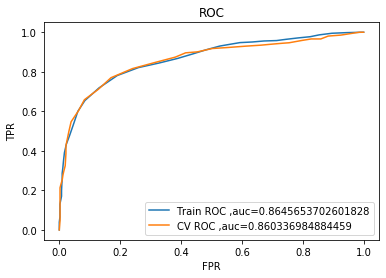

In [33]:
knn=KNeighborsClassifier(n_neighbors=35,weights='uniform',algorithm='brute',leaf_size=30, p=2, metric='cosine')
knn.fit(final_Xtr,y_tr)
predi=knn.predict_proba(final_Xtr)[:,1]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_tr, predi)
pred=knn.predict_proba(final_Xcv)[:,1]
fpr2,tpr2,thresholds2=metrics.roc_curve(y_cv,pred)
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(fpr1, tpr1, label='Train ROC ,auc='+str(roc_auc_score(y_tr,predi)))
ax.plot(fpr2, tpr2, label='CV ROC ,auc='+str(roc_auc_score(y_cv,pred)))
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
ax.legend()
plt.show()

In [34]:
class TwitterClient(object): 
    ''' 
    Generic Twitter Class for sentiment analysis. 
    '''
    def __init__(self): 
        ''' 
        Class constructor or initialization method. 
        '''
        # keys and tokens from the Twitter Dev Console 
        
   
      
        # attempt authentication 
        try: 
            # create OAuthHandler object 
            self.auth = OAuthHandler(consumer_key, consumer_secret) 
            # set access token and secret 
            self.auth.set_access_token(access_token, access_token_secret) 
            # create tweepy API object to fetch tweets 
            self.api = tweepy.API(self.auth) 
        except: 
            print("Error: Authentication Failed") 
  
    def clean_tweet(self, tweet): 
        ''' 
        Utility function to clean tweet text by removing links, special characters 
        using simple regex statements. 
        '''
        return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t]) |(\w+:\/\/\S+)", " ", tweet).split()) 
  
    def get_tweet_sentiment(self, tweet): 
        ''' 
        Utility function to classify sentiment of passed tweet 
        using textblob's sentiment method 
        '''
        # create TextBlob object of passed tweet text 
        analysis = TextBlob(self.clean_tweet(tweet)) 
        # set sentiment 
        if analysis.sentiment.polarity > 0: 
            return 'positive'
        elif analysis.sentiment.polarity == 0: 
            return 'neutral'
        else: 
            return 'negative'
  
    def get_tweets(self, query, count = 10): 
        ''' 
        Main function to fetch tweets and parse them. 
        '''
        # empty list to store parsed tweets 
        tweets = [] 
  
        try: 
            # call twitter api to fetch tweets 
            fetched_tweets = self.api.search(q = query, count = count) 
  
            # parsing tweets one by one 
            for tweet in fetched_tweets: 
                # empty dictionary to store required params of a tweet 
                parsed_tweet = {} 
  
                # saving text of tweet 
                parsed_tweet['text'] = tweet.text 
                # saving sentiment of tweet 
                parsed_tweet['sentiment'] = self.get_tweet_sentiment(tweet.text) 
  
                # appending parsed tweet to tweets list 
                if tweet.retweet_count > 0: 
                    # if tweet has retweets, ensure that it is appended only once 
                    if parsed_tweet not in tweets: 
                        tweets.append(parsed_tweet) 
                else: 
                    tweets.append(parsed_tweet) 
  
            # return parsed tweets 
            return tweets 
  
        except tweepy.TweepError as e: 
            # print error (if any) 
            print("Error : " + str(e)) 
  

In [35]:
def main(): 
    # creating object of TwitterClient Class 
    api = TwitterClient() 
    # calling function to get tweets 
    tweets = api.get_tweets(query = data_to_be_discussed, count = 200) 
  
    # picking positive tweets from tweets 
    ptweets = [tweet for tweet in tweets if tweet['sentiment'] == 'positive'] 
    # percentage of positive tweets 
    print("Positive tweets percentage: {} %".format(100*len(ptweets)/len(tweets))) 
    # picking negative tweets from tweets 
    ntweets = [tweet for tweet in tweets if tweet['sentiment'] == 'negative'] 
    # percentage of negative tweets 
    print("Negative tweets percentage: {} %".format(100*len(ntweets)/len(tweets))) 
    # percentage of neutral tweets 
    print("Neutral tweets percentage: {} % ".format(100*(len(tweets) - len(ntweets) - len(ptweets))/len(tweets))) 
  
    # printing first 5 positive tweets 
    print("\n\nPositive tweets:") 
    for tweet in ptweets[:10]: 
        print(tweet['text']) 
  
    # printing first 5 negative tweets 
    print("\n\nNegative tweets:") 
    for tweet in ntweets[:10]: 
        print(tweet['text']) 
    
    with open("tweets after sentimental anlaysis.txt", "w") as output:
        output.write(str(tweets))
    
if __name__ == "__main__": 
    # calling main function 
    main() 


Positive tweets percentage: 33.333333333333336 %
Negative tweets percentage: 22.22222222222222 %
Neutral tweets percentage: 44.44444444444444 % 


Positive tweets:
@Ath_Recruiter How shitty for the people waiting for the lockdown to be lifted so they can figure out if their love… https://t.co/0IP4l2DUao
RT @ronanburtenshaw: Life-changing fines handed out to working-class people by a government that either doesn't know its own lockdown rules…
RT @Leratompunzi1: Di pregnancy tsa Lockdown di cute nyana yang. O kgona go bona gore bana ba teng ba dirilwe gosa jagiwa, go sena le botag…
RT @d_mos77: You didnt really think it was going to set you free did you? 😂😂😂
https://t.co/bFf02cfpPd
RT @DrMadej: Any good, scientific study before or after the lockdown has shown that masks do NOT work for decreasing CV19 or any other viru…
RT @patty_sawicki: 1) #Covid19 is NOT worse than other viral pandemics we've been through (w/o lockdown,distancing,masks) so WHY is this on…
A great initiative from @Boor